In [11]:
def annotate_celltypist(
    merged_h5ad_path: str,
    model_path: str,
    out_dir: str,
    target_sum: float = 1e4,
):
    """
    Runs CellTypist per sample, saves per-sample and global predictions.
    Skips any sample where both predicted_labels and probability_matrix CSVs exist,
    but still loads them into the global outputs.
    """
    ensure_dir(out_dir)
    adata = sc.read_h5ad(merged_h5ad_path)

    # Load model
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    model = celltypist.models.Model.load(model=model_path)

    all_prob_dfs = []
    all_pred_dfs = []
    processed, skipped = [], []

    # Precompute cell counts per sample for logging
    counts = adata.obs['Sanger_ID'].value_counts().to_dict()

    for sanger in adata.obs['Sanger_ID'].unique():
        samp_out = os.path.join(out_dir, sanger)
        ensure_dir(samp_out)

        pred_csv = os.path.join(samp_out, f"predicted_labels_{model_name}_{sanger}.csv")
        prob_csv = os.path.join(samp_out, f"probability_matrix_{model_name}_{sanger}.csv")

        # SKIP existing outputs
        if os.path.exists(pred_csv) and os.path.exists(prob_csv):
            logging.info(f"[CellTypist] Skipping {sanger} ({counts[sanger]} cells): outputs exist")
            # load existing probability matrix
            prob_df = pd.read_csv(prob_csv, index_col=0)
            prob_df.index.name = 'Cell_ID'
            all_prob_dfs.append(prob_df)
            # load existing predictions
            pred_df = pd.read_csv(pred_csv)
            if 'Cell_ID' not in pred_df.columns:
                pred_df = pred_df.rename_axis('Cell_ID').reset_index()
            pred_df['Sanger_ID'] = sanger
            all_pred_dfs.append(pred_df)
            skipped.append(sanger)
            continue

        # PROCESS new sample
        logging.info(f"[CellTypist] Processing {sanger} ({counts[sanger]} cells)")
        subset = adata[adata.obs['Sanger_ID'] == sanger].copy()
        sc.pp.normalize_total(subset, target_sum=target_sum)
        sc.pp.log1p(subset)

        result = celltypist.annotate(
            subset,
            model=model,
            majority_voting=True,
        )

        # DataFrames
        pred_df = result.predicted_labels.copy()
        prob_df = result.probability_matrix.copy()

        # Save per-sample outputs
        pred_df.to_csv(pred_csv)
        result.decision_matrix.to_csv(os.path.join(
            samp_out, f"decision_matrix_{model_name}_{sanger}.csv"))
        prob_df.to_csv(prob_csv)
        result.adata.write_h5ad(os.path.join(
            samp_out, f"{model_name}_{sanger}_celltypist_annotated.h5ad"))

        # Collect for global
        prob_df.index.name = 'Cell_ID'
        all_prob_dfs.append(prob_df)

        if 'Cell_ID' not in pred_df.columns:
            tmp = pred_df.rename_axis('Cell_ID').reset_index()
        else:
            tmp = pred_df.copy()
        tmp['Sanger_ID'] = sanger
        all_pred_dfs.append(tmp)

        processed.append(sanger)

    # Global concatenation & save
    big_probs = pd.concat(all_prob_dfs, axis=0)
    big_probs.to_csv(os.path.join(out_dir, 'all_samples_probability_matrix.csv'))

    big_preds = pd.concat(all_pred_dfs, axis=0)
    cols = ['Cell_ID','Sanger_ID'] + [c for c in big_preds.columns
                                     if c not in ('Cell_ID','Sanger_ID')]
    big_preds[cols].to_csv(os.path.join(out_dir, 'all_samples_predictions.csv'),
                           index=False)

    # Summary logging
    total = len(adata.obs['Sanger_ID'].unique())
    logging.info(f"[CellTypist] Done: {len(processed)} processed, {len(skipped)} skipped, out of {total} samples.")
    for s, n in counts.items():
        logging.info(f"  Sample {s}: {n} cells")

    return big_probs, big_preds


def ensure_dir(path):
    """
    Ensure that a directory exists.
    If it does not, create it (including any necessary parent directories).
    """
    os.makedirs(path, exist_ok=True)

def find_h5_file(sample_dir, key='filtered'):
    """
    Locate the single .h5 file in sample_dir containing 'key'.
    Returns the full path, or raises FileNotFoundError/ValueError.
    """
    files = [f for f in os.listdir(sample_dir) 
             if key in f and f.endswith('.h5')]
    if len(files) == 0:
        raise FileNotFoundError(f"No H5 file containing '{key}' in {sample_dir}")
    if len(files) > 1:
        raise ValueError(f"Multiple H5 files containing '{key}' in {sample_dir}: {files}")
    return os.path.join(sample_dir, files[0])


def get_logger(name=__name__):
    """
    Return a logger that prints INFO-level messages to stdout.
    """
    logger = logging.getLogger(name)
    if not logger.handlers:
        handler = logging.StreamHandler()
        fmt = '%(asctime)s %(levelname)-8s %(message)s'
        handler.setFormatter(logging.Formatter(fmt))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
    return logger

In [1]:
import celltypist 
import scanpy as sc 
import utils
import os
import logging
import pandas as pd

In [ ]:
annotate_celltypist(merged_h5ad_path='/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_unfiltered.h5ad',
                         model_path= '/nfs/team298/sm54/BoneAtlasProject/metadata/celltypist_models/Human_WholeEmbryo_Public.pkl',
                   out_dir='/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/')

In [1]:
import scanpy as sc 
adata= sc.read_h5ad('/nfs/team298/sm54/skull_data_sharing/skull_object_with_annotations_with_raw_counts.h5ad')

In [7]:
import pandas as pd
pd.crosstab(adata.obs["Donor"],adata.obs["PCW"])

PCW,5.7,5.8,7.3,7.6,8.0,8.3,8.5,8.6,9.4,10.0,10.3,11.2,12.0
Donor,,,,,,,,,,,,,
2358.0,0,0,0,0,11896,0,0,0,0,0,0,0,0
2361,0,0,0,0,0,0,35253,0,0,0,0,0,0
2361.0,0,0,0,0,0,0,9389,0,0,0,0,0,0
2365,0,0,0,0,0,0,0,0,0,0,18748,0,0
2365.0,0,0,0,0,0,0,0,0,0,0,9990,0,0
2368,0,0,0,0,0,3789,0,0,0,0,0,0,0
2368.0,0,0,0,0,0,7222,0,0,0,0,0,0,0
2369,0,0,0,22267,0,0,0,0,0,0,0,0,0
2369.0,0,0,0,12121,0,0,0,0,0,0,0,0,0


In [9]:
adata.obs["Donor"].value_counts()

Donor
2384                   124673
nan                     56638
2372                    38495
2393                    36884
2382                    36040
2361                    35253
2384.0                  31464
2372.0                  30232
2370.0                  29819
2382.0                  25831
Sst2-BON-0-FO-6to8      24393
2369                    22267
2365                    18748
2394                    18606
Sst2-BON-0-FO-1to3      17737
Sst2-BON-0-FO-9to11     15989
2392                    14099
Sst2-BON-0-FO-4to5      13810
2369.0                  12121
2358.0                  11896
2392.0                  11682
2365.0                   9990
2361.0                   9389
2394.0                   8270
2368.0                   7222
2370                     4868
2368                     3789
2393.0                   3375
Name: count, dtype: int64

In [10]:
# 1) Make sure it’s stringly-typed
adata.obs["Donor"] = adata.obs["Donor"].astype(str)

# 2) Remove any trailing “.0”
adata.obs["Donor"] = adata.obs["Donor"].str.replace(r"\.0$", "", regex=True)

# 3) Collapse all Sst2-BON-0-FO variants into one name
adata.obs["Donor"] = adata.obs["Donor"].str.replace(
    r"^Sst2-BON-0-FO.*$", 
    "Sst2-BON-0-FO-6to8", 
    regex=True
)

# 4) Check your work
print(adata.obs["Donor"].value_counts())


Donor
2384                  156137
Sst2-BON-0-FO-6to8     71929
2372                   68727
2382                   61871
nan                    56638
2361                   44642
2393                   40259
2370                   34687
2369                   34388
2365                   28738
2394                   26876
2392                   25781
2358                   11896
2368                   11011
Name: count, dtype: int64


In [11]:
pd.crosstab(adata.obs["Donor"],adata.obs["PCW"])

PCW,5.7,5.8,7.3,7.6,8.0,8.3,8.5,8.6,9.4,10.0,10.3,11.2,12.0
Donor,,,,,,,,,,,,,
2358,0,0,0,0,11896,0,0,0,0,0,0,0,0
2361,0,0,0,0,0,0,44642,0,0,0,0,0,0
2365,0,0,0,0,0,0,0,0,0,0,28738,0,0
2368,0,0,0,0,0,11011,0,0,0,0,0,0,0
2369,0,0,0,34388,0,0,0,0,0,0,0,0,0
2370,0,34687,0,0,0,0,0,0,0,0,0,0,0
2372,0,0,0,0,0,0,0,0,0,0,0,68727,0
2382,0,0,0,0,0,0,0,0,0,61871,0,0,0
2384,0,0,0,0,0,0,0,0,156137,0,0,0,0


In [18]:
adata.obs['Run_ID']

cell_id
HCA_BN_F13109713_and_HCA_BN_F13101383-TAAGCCTAGGGACCTC-1    HCA_BN_F13109713_and_HCA_BN_F13101383
HCA_BN_F13109713_and_HCA_BN_F13101383-CGCACAATCCAGGTTG-1    HCA_BN_F13109713_and_HCA_BN_F13101383
HCA_BN_F13109713_and_HCA_BN_F13101383-CGCTTCTAGGATTGCT-1    HCA_BN_F13109713_and_HCA_BN_F13101383
HCA_BN_F13109713_and_HCA_BN_F13101383-CTTTAGTTCCCAGTAG-1    HCA_BN_F13109713_and_HCA_BN_F13101383
HCA_BN_F13109713_and_HCA_BN_F13101383-CTGACCAAGGCTGTGC-1    HCA_BN_F13109713_and_HCA_BN_F13101383
                                                                            ...                  
HCA_BN_F12482363_and_HCA_BN_F12477275-TCACATAAGCTATGAC-1    HCA_BN_F12482363_and_HCA_BN_F12477275
HCA_BN_F12482363_and_HCA_BN_F12477275-TTAGCGGTCCTTAGGG-1    HCA_BN_F12482363_and_HCA_BN_F12477275
HCA_BN_F12482363_and_HCA_BN_F12477275-GAGATAAGTTGAAGCC-1    HCA_BN_F12482363_and_HCA_BN_F12477275
HCA_BN_F12482363_and_HCA_BN_F12477275-TGCAAGCGTTAGCATG-1    HCA_BN_F12482363_and_HCA_BN_F12477275
HCA_BN_F1248

In [20]:
adata.obs["barcode_raw"] = adata.obs['barcode'].str.rsplit('-', n=1).str[0]
adata.obs['Sample_ID'] = adata.obs['Run_ID'].str.split('_and_').str[0]
adata.obs["Cell_ID"]=adata.obs["barcode_raw"].astype(str) + '-' + adata.obs["Sample_ID"].astype(str) 

In [21]:
adata.obs["Cell_ID"]

cell_id
HCA_BN_F13109713_and_HCA_BN_F13101383-TAAGCCTAGGGACCTC-1    TAAGCCTAGGGACCTC-HCA_BN_F13109713
HCA_BN_F13109713_and_HCA_BN_F13101383-CGCACAATCCAGGTTG-1    CGCACAATCCAGGTTG-HCA_BN_F13109713
HCA_BN_F13109713_and_HCA_BN_F13101383-CGCTTCTAGGATTGCT-1    CGCTTCTAGGATTGCT-HCA_BN_F13109713
HCA_BN_F13109713_and_HCA_BN_F13101383-CTTTAGTTCCCAGTAG-1    CTTTAGTTCCCAGTAG-HCA_BN_F13109713
HCA_BN_F13109713_and_HCA_BN_F13101383-CTGACCAAGGCTGTGC-1    CTGACCAAGGCTGTGC-HCA_BN_F13109713
                                                                          ...                
HCA_BN_F12482363_and_HCA_BN_F12477275-TCACATAAGCTATGAC-1    TCACATAAGCTATGAC-HCA_BN_F12482363
HCA_BN_F12482363_and_HCA_BN_F12477275-TTAGCGGTCCTTAGGG-1    TTAGCGGTCCTTAGGG-HCA_BN_F12482363
HCA_BN_F12482363_and_HCA_BN_F12477275-GAGATAAGTTGAAGCC-1    GAGATAAGTTGAAGCC-HCA_BN_F12482363
HCA_BN_F12482363_and_HCA_BN_F12477275-TGCAAGCGTTAGCATG-1    TGCAAGCGTTAGCATG-HCA_BN_F12482363
HCA_BN_F12482363_and_HCA_BN_F12477275-GCTAAGTTCACAAG

In [22]:
adata.obs.to_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/old_annotations/skull_metadata_old_version_2.csv')

In [1]:
import scanpy as sc 

In [2]:
adata= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_filtered_with_metadata_pca.h5ad') 

In [3]:
adata

AnnData object with n_obs × n_vars = 1566868 × 2500
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unf

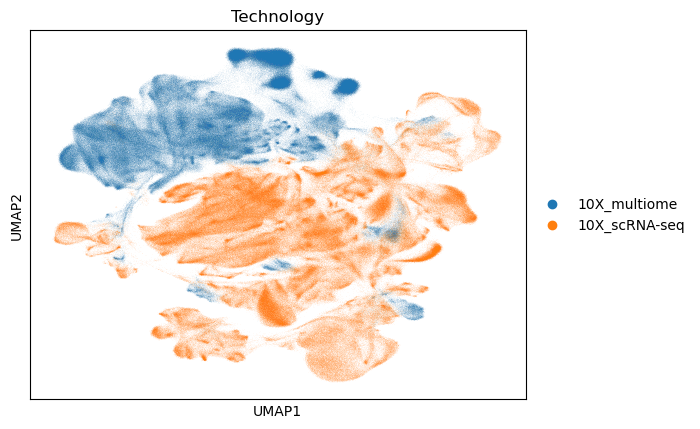

In [5]:
sc.pl.umap(adata,color= "Technology")

In [ ]:
adata= sc.read_h5ad('/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_filtered_with_metadata_scvi.h5ad') 

In [2]:
adata= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/best_integration/processed_adata/Best_Integration_bone_atlas_nlatent30_nlayers3_nhidden128_nhvg3000_with_leiden_clustering.h5ad') 

In [3]:
adata

AnnData object with n_obs × n_vars = 1566871 × 3000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unf

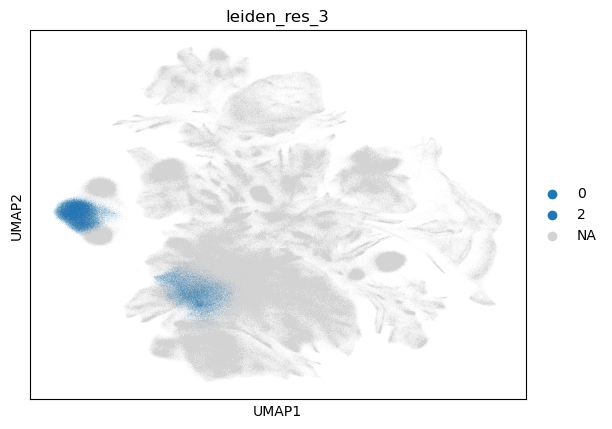

In [9]:
sc.pl.umap(adata, color='leiden_res_3', palette='tab20',groups=['0','2'])